## OCR 수행


In [ ]:
# 1. 필요한 패키지 설치
!pip install easyocr
!pip install torch torchvision
!pip install tqdm pandas


# GPU 확인
import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU model:", torch.cuda.get_device_name(0))
    !nvidia-smi  # GPU 상태 확인

import torch
import easyocr
import re
import json
import os
import pandas as pd
from datetime import datetime
import unicodedata
from tqdm import tqdm
from PIL import Image
from google.colab import drive


# 3. Google Drive 마운트
drive.mount('/content/drive')

class KoreanOCR:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")

        print("Initializing EasyOCR (this might take a while on first run)...")
        self.reader = easyocr.Reader(['ko'], gpu=self.device=='cuda')
        print("OCR model loaded successfully!")

    def recognize_text(self, image_path):
        """이미지에서 텍스트 인식"""
        try:
            results = self.reader.readtext(image_path)
            text = ' '.join([result[1] for result in results])
            return text
        except Exception as e:
            print(f"Error recognizing text: {str(e)}")
            return ""

def create_core_financial_patterns():
    """핵심 신용등급 예측을 위한 간결한 정보 추출 패턴 생성"""
    patterns = {
        'balance_sheet': r'(?:재무상태표|재무상태|자산총계|부채총계|자본총계)[\s\S]*?(?=영업이익|다음|$)',
        'income_statement': r'(?:손익계산서|포괄손익계산서|매출액|영업이익|당기순이익)[\s\S]*?(?=자산|다음|$)',
        'credit_info': r'(?:신용등급|신용평가|등급전망|신용위험|채무불이행|리스크)[\s\S]*?(?=재무|다음|$)',
        'board_and_management': r'(?:이사회 의견|이사회 결정|경영진 논의|경영진 평가|경영진 의견)[\s\S]*?(?=재무|다음|$)',
        'footnotes': r'(?:주석|비고|추가정보|기타사항|부기사항|특기사항)[\s\S]*?(?=재무|다음|$)'
    }

    combined_pattern = '|'.join(f'({pattern})' for pattern in patterns.values())
    return combined_pattern

def extract_financial_data(text, pattern=None):
    """재무 관련 정보 추출 및 정제"""
    if pattern is None:
        pattern = create_financial_patterns()

    matches = re.finditer(pattern, text, re.MULTILINE | re.DOTALL)
    extracted_texts = []

    for match in matches:
        extracted_text = match.group()
        extracted_text = re.sub(r'\s+', ' ', extracted_text).strip()
        extracted_text = re.sub(r'[^\w\s.()%+-]', '', extracted_text)
        extracted_texts.append(extracted_text)

    unique_texts = list(dict.fromkeys(extracted_texts))
    return ' '.join(unique_texts)

def process_folder(folder_path, save_path, label, mode='TRAIN'):
    """폴더 내 모든 이미지 처리"""
    try:
        company_name = os.path.basename(folder_path).split(']')[0].replace('[', '').replace(" ", "").strip()
        company_name = unicodedata.normalize('NFC', company_name)

        ocr = KoreanOCR()
        all_texts = []

        image_files = sorted([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))
        ])

        if not image_files:
            print("No image files found in the specified folder!")
            return "", pd.DataFrame()

        print(f"Found {len(image_files)} image files")

        for image_file in tqdm(image_files, desc="Processing images"):
            try:
                image_path = os.path.join(folder_path, image_file)
                recognized_text = ocr.recognize_text(image_path)
                all_texts.append(recognized_text)
            except Exception as e:
                print(f"Error processing {image_file}: {str(e)}")

        combined_text = ' '.join(all_texts)
        financial_text = extract_financial_data(combined_text)

        result_df = pd.DataFrame({
            'company': [company_name],
            'credit_rating': [label],
            'financial_text': [financial_text],
            'timestamp': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')]
        })

        result = {
            'company': company_name,
            'credit_rating': label,
            'financial_text': financial_text,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        os.makedirs(save_path, exist_ok=True)
        json_base_path = os.path.join(save_path, 'JSON')
        json_save_path = os.path.join(json_base_path, mode)
        os.makedirs(json_save_path, exist_ok=True)

        json_filename = os.path.join(json_save_path, f'{company_name}.json')
        with open(json_filename, 'w', encoding='utf-8') as json_file:
            json.dump(result, json_file, ensure_ascii=False, indent=4)

        return combined_text, result_df

    except Exception as e:
        print(f"Error in process_folder: {str(e)}")
        return "", pd.DataFrame()

GPU available: True
GPU model: Tesla T4
Sun Oct 27 17:51:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              26W /  70W |   4187MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------------------

In [ ]:
def process_all_folders(base_folder, save_folder, credit_rating_df):
    """모든 폴더 처리"""
    os.makedirs(save_folder, exist_ok=True)

    train_folder = os.path.join(base_folder, "TRAIN")
    test_folder = os.path.join(base_folder, "TEST")

    train_subfolders = sorted([f.path for f in os.scandir(train_folder) if f.is_dir()])
    test_subfolders = sorted([f.path for f in os.scandir(test_folder) if f.is_dir()])

    total_folders = len(train_subfolders) + len(test_subfolders)
    print(f"총 처리할 폴더 수: {total_folders}")
    print(f"신용등급 데이터의 기업 수: {len(credit_rating_df)}")

    credit_rating_df['기업명_normalized'] = credit_rating_df['기업명'].apply(
        lambda x: unicodedata.normalize('NFC', str(x).strip())
    )

    def get_company_info(folder_path):
        """회사명 추출 및 신용등급 찾기"""
        try:
            company_name = os.path.basename(folder_path).split(']')[0].replace('[', '').strip()
            company_name = unicodedata.normalize('NFC', company_name)

            matching_companies = credit_rating_df[credit_rating_df['기업명_normalized'] == company_name]

            if len(matching_companies) == 0:
                print(f"경고: {company_name}에 대한 신용등급 정보를 찾을 수 없습니다.")
                return None, None

            if len(matching_companies) > 1:
                print(f"경고: {company_name}에 대해 중복된 신용등급 정보가 있습니다.")

            credit_rating = matching_companies['신용등급'].iloc[0]
            return company_name, credit_rating

        except Exception as e:
            print(f"회사 정보 추출 중 오류 발생: {str(e)}")
            return None, None

    def process_subset(subfolders, mode, pbar_desc):
        """TRAIN/TEST 서브폴더 처리"""
        results = []
        failed_companies = []

        for folder in tqdm(subfolders, desc=pbar_desc):
            company_name, credit_rating = get_company_info(folder)

            if company_name is None or credit_rating is None:
                failed_companies.append(os.path.basename(folder))
                continue

            try:
                full_text, result_df = process_folder(
                    folder_path=folder,
                    save_path=save_folder,
                    label=credit_rating,
                    mode=mode
                )

                if not result_df.empty:
                    results.append(result_df)

            except Exception as e:
                failed_companies.append(os.path.basename(folder))
                print(f"\n{company_name} 처리 중 오류 발생: {str(e)}")

        return results, failed_companies

    print("\nTRAIN 폴더 처리 중...")
    train_results, train_failed = process_subset(
        train_subfolders,
        'TRAIN',
        'Processing TRAIN folders'
    )

    print("\nTEST 폴더 처리 중...")
    test_results, test_failed = process_subset(
        test_subfolders,
        'TEST',
        'Processing TEST folders'
    )

    failed_cases = train_failed + test_failed
    if failed_cases:
        failed_log = os.path.join(save_folder, 'failed_cases.txt')
        with open(failed_log, 'w', encoding='utf-8') as f:
            f.write('\n'.join(failed_cases))
        print(f"\n처리 실패한 케이스들이 {failed_log}에 저장되었습니다.")

    all_results = train_results + test_results
    if not all_results:
        print("처리된 결과가 없습니다!")
        return pd.DataFrame()

    final_df = pd.concat(all_results, ignore_index=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    csv_filename = os.path.join(save_folder, f'combined_results_{timestamp}.csv')
    final_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')

    summary = {
        'total_companies': len(final_df),
        'unique_companies': len(final_df['company'].unique()),
        'credit_rating_distribution': final_df['credit_rating'].value_counts().to_dict(),
        'processing_timestamp': timestamp,
        'failed_cases_count': len(failed_cases)
    }

    summary_filename = os.path.join(save_folder, f'processing_summary_{timestamp}.json')
    with open(summary_filename, 'w', encoding='utf-8') as f:
        json.dump(summary, f, ensure_ascii=False, indent=4)

    print(f"\n처리 완료!")
    print(f"- 총 처리된 기업 수: {len(final_df)}")
    print(f"- 실패한 케이스 수: {len(failed_cases)}")
    print(f"- 결과 저장 위치: {csv_filename}")
    print(f"- 요약 정보 저장 위치: {summary_filename}")

    return final_df

In [ ]:
if __name__ == "__main__":
    # CUDA 사용 가능 여부 확인
    print("CUDA 사용 가능 여부:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("사용 중인 GPU:", torch.cuda.get_device_name(0))

    # Google Drive 마운트 (Colab 사용시)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive가 마운트되었습니다.")
    except:
        print("로컬 환경에서 실행 중입니다.")

    # 경로 설정
    base_folder = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/data"
    save_folder = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results"

    # 기업 이름과 신용등급을 리스트로 구성
    data = {
        "기업명": [
            "경남은행", "광동제약", "교보증권", "기업은행", "깨끗한나라", "대상", "동국산업", "동부건설",
            "매일홀딩스", "부산은행", "비씨카드", "빙그레", "삼성증권", "셀트리온헬스케어", "송원산업",
            "신세계푸드", "신한은행", "아이비케이투자증권", "아이엠뱅크", "우리은행", "우리카드",
            "이수화학", "이지홀딩스", "제주은행", "케이비국민카드", "키움증권", "한국스탠다드차타드은행",
            "한국자산신탁", "한국증권금융", "한화엔진", "한화투자증권", "HDC", "KB금융", "SFA반도체"
        ],
        "신용등급": [
            "AA+", "A", "A+", "AAA", "BBB", "A+", "BBB+", "BBB", "A+", "AAA",
            "AA+", "AA-", "AA+", "A+", "A-", "A+", "AAA", "A", "AAA", "AAA",
            "AA", "BBB-", "BBB+", "AA+", "AA+", "AA-", "AAA", "A-", "AAA",
            "BB+", "A+", "A+", "AAA", "BBB"
        ]
    }

    # 데이터프레임 생성
    credit_rating_df = pd.DataFrame(data)

    try:
        # 처리 시작 시간 기록
        start_time = datetime.now()
        print(f"처리 시작 시간: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

        # 전체 처리 실행
        final_results = process_all_folders(base_folder, save_folder, credit_rating_df)

        # 처리 완료 시간 및 소요 시간 계산
        end_time = datetime.now()
        processing_time = end_time - start_time

        print(f"\n처리 완료 시간: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"총 소요 시간: {processing_time}")

        # 결과 요약
        if not final_results.empty:
            print("\n처리 결과 요약:")
            print(f"- 전체 처리된 문서 수: {len(final_results)}")
            print(f"- 고유 기업 수: {len(final_results['company'].unique())}")
            print("\n신용등급 분포:")
            print(final_results['credit_rating'].value_counts())

    except Exception as e:
        print(f"\n처리 중 오류 발생: {str(e)}")
        raise

CUDA 사용 가능 여부: True
사용 중인 GPU: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive가 마운트되었습니다.
처리 시작 시간: 2024-10-27 17:51:16
총 처리할 폴더 수: 12
신용등급 데이터의 기업 수: 34

TRAIN 폴더 처리 중...


Processing TRAIN folders:   0%|          | 0/4 [00:00<?, ?it/s]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 343 image files



Processing TRAIN folders:  25%|██▌       | 1/4 [16:42<50:06, 1002.25s/it]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 360 image files



Processing TRAIN folders:  50%|█████     | 2/4 [31:52<31:36, 948.28s/it] 

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 341 image files



Processing TRAIN folders:  75%|███████▌  | 3/4 [48:55<16:22, 982.29s/it]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 504 image files



Processing TRAIN folders: 100%|██████████| 4/4 [1:14:30<00:00, 1117.52s/it]



TEST 폴더 처리 중...


Processing TEST folders:   0%|          | 0/8 [00:00<?, ?it/s]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 408 image files



Processing TEST folders:  12%|█▎        | 1/8 [17:51<2:04:57, 1071.02s/it]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 874 image files



Processing TEST folders:  25%|██▌       | 2/8 [1:07:59<3:41:05, 2210.95s/it]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 183 image files



Processing TEST folders:  38%|███▊      | 3/8 [1:16:20<1:59:10, 1430.05s/it]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 512 image files



Processing TEST folders:  50%|█████     | 4/8 [1:36:42<1:29:51, 1347.97s/it]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 301 image files



Processing TEST folders:  62%|██████▎   | 5/8 [1:49:14<56:38, 1132.96s/it]  

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 312 image files



Processing TEST folders:  75%|███████▌  | 6/8 [2:02:52<34:11, 1025.83s/it]

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 332 image files



Processing TEST folders:  88%|████████▊ | 7/8 [2:17:12<16:11, 971.76s/it] 

Using device: cuda
Initializing EasyOCR (this might take a while on first run)...
OCR model loaded successfully!
Found 465 image files



Processing TEST folders: 100%|██████████| 8/8 [2:39:40<00:00, 1197.53s/it]



처리 완료!
- 총 처리된 기업 수: 12
- 실패한 케이스 수: 0
- 결과 저장 위치: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/combined_results_20241027_214526.csv
- 요약 정보 저장 위치: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/processing_summary_20241027_214526.json

처리 완료 시간: 2024-10-27 21:45:26
총 소요 시간: 3:54:10.539152

처리 결과 요약:
- 전체 처리된 문서 수: 12
- 고유 기업 수: 12

신용등급 분포:
credit_rating
AAA     3
AA+     2
A+      2
BBB+    1
AA-     1
BBB     1
A-      1
BB+     1
Name: count, dtype: int64


In [ ]:
import pandas as pd
import json
import os
import re
from datetime import datetime
from tqdm import tqdm

def create_core_financial_patterns():
    """핵심 신용등급 예측을 위한 간결한 정보 추출 패턴 생성"""
    patterns = {
        'balance_sheet': r'(?:재무상태표|재무상태|자산총계|부채총계|자본총계)[\s\S]*?(?=영업이익|다음|$)',
        'income_statement': r'(?:손익계산서|포괄손익계산서|매출액|영업이익|당기순이익)[\s\S]*?(?=자산|다음|$)',
        'credit_info': r'(?:신용등급|신용평가|등급전망|신용위험|채무불이행|리스크)[\s\S]*?(?=재무|다음|$)',
        'board_and_management': r'(?:이사회 의견|이사회 결정|경영진 논의|경영진 평가|경영진 의견)[\s\S]*?(?=재무|다음|$)',
        'footnotes': r'(?:주석|비고|추가정보|기타사항|부기사항|특기사항)[\s\S]*?(?=재무|다음|$)'
    }

    combined_pattern = '|'.join(f'({pattern})' for pattern in patterns.values())
    return combined_pattern

def extract_financial_data(text, pattern=None):
    """재무 관련 정보 추출 및 정제"""
    if pattern is None:
        pattern = create_core_financial_patterns()

    if pd.isna(text):  # None이나 NaN 값 처리
        return ""

    matches = re.finditer(pattern, text, re.MULTILINE | re.DOTALL)
    extracted_texts = []

    for match in matches:
        extracted_text = match.group()
        extracted_text = re.sub(r'\s+', ' ', extracted_text).strip()
        extracted_text = re.sub(r'[^\w\s.()%+-]', '', extracted_text)
        extracted_texts.append(extracted_text)

    unique_texts = list(dict.fromkeys(extracted_texts))
    return ' '.join(unique_texts)

def process_company_data(train_dir, json_output_dir, mode='TRAIN'):
    """TRAIN/TEST 디렉토리 내의 모든 기업 CSV 파일 처리"""
    try:
        # 출력 디렉토리 생성
        json_output_path = os.path.join(json_output_dir, mode)
        os.makedirs(json_output_path, exist_ok=True)

        # TRAIN/TEST 디렉토리 내의 모든 CSV 파일 찾기
        csv_files = []
        for root, _, files in os.walk(train_dir):
            for file in files:
                if file.endswith('.csv'):
                    csv_files.append(os.path.join(root, file))

        print(f"발견된 CSV 파일 수: {len(csv_files)}")

        # 각 CSV 파일 처리
        for csv_path in tqdm(csv_files, desc=f"Processing {mode} data"):
            try:
                # CSV 파일 읽기
                df = pd.read_csv(csv_path)

                # 회사명 추출 (디렉토리명에서)
                company_name = df['company'].values[0]
                company_name = company_name.split(']')[0].replace('[', '').strip()
                company_name = f"{company_name}분기"

                # 텍스트 데이터 결합 및 처리
                all_texts = ' '.join(df['text'].fillna('').astype(str))
                processed_text = extract_financial_data(all_texts)

                # JSON 데이터 구조 생성
                json_data = {
                    'company': company_name,
                    'credit_rating': df['label'].iloc[0] if not df['label'].empty else '',  # 첫 번째 label 사용
                    'financial_text': processed_text,
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                }

                # JSON 파일 저장
                json_filename = f"{company_name}.json"
                json_filepath = os.path.join(json_output_path, json_filename)
                print(json_filename)

                with open(json_filepath, 'w', encoding='utf-8') as f:
                    json.dump(json_data, f, ensure_ascii=False, indent=4)

            except Exception as e:
                print(f"Error processing {csv_path}: {str(e)}")
                continue

        print(f"{mode} 데이터 변환 완료: {json_output_path}")
        return True

    except Exception as e:
        print(f"오류 발생: {str(e)}")
        return False

if __name__ == "__main__":
    # 사용 예시
    base_dir = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/CSV"  # 기본 디렉토리
    train_dir = os.path.join(base_dir, "TRAIN")  # TRAIN 디렉토리
    test_dir = os.path.join(base_dir, "TEST")    # TEST 디렉토리
    json_output_dir = os.path.join(base_dir, "JSON")  # JSON 출력 디렉토리

    # TRAIN 데이터 처리
    print("TRAIN 데이터 처리 중...")
    process_company_data(train_dir, json_output_dir, mode='TRAIN')

    # TEST 데이터 처리
    print("\nTEST 데이터 처리 중...")
    process_company_data(test_dir, json_output_dir, mode='TEST')

TRAIN 데이터 처리 중...
발견된 CSV 파일 수: 44


Processing TRAIN data:   5%|▍         | 2/44 [00:00<00:02, 15.81it/s]

동부건설분기.json
DB금융투자분기.json
HDC분기.json


Processing TRAIN data:   9%|▉         | 4/44 [00:00<00:03, 11.10it/s]

JB금융지주분기.json
JW중외제약분기.json


Processing TRAIN data:  14%|█▎        | 6/44 [00:00<00:02, 13.92it/s]

JW홀딩스분기.json
KB금융분기.json


Processing TRAIN data:  18%|█▊        | 8/44 [00:00<00:03, 11.37it/s]

SFA반도체분기.json
SK네트웍스분기.json


Processing TRAIN data:  23%|██▎       | 10/44 [00:00<00:02, 12.09it/s]

SK증권분기.json
매일홀딩스분기.json


Processing TRAIN data:  27%|██▋       | 12/44 [00:00<00:02, 13.55it/s]

부산은행분기.json
비씨카드분기.json
빙그레분기.json


Processing TRAIN data:  34%|███▍      | 15/44 [00:01<00:01, 15.89it/s]

삼성EA분기.json


Processing TRAIN data:  39%|███▊      | 17/44 [00:01<00:01, 14.40it/s]

삼성SDI분기.json
삼성증권분기.json
셀트리온헬스케어분기.json
송원산업분기.json


Processing TRAIN data:  45%|████▌     | 20/44 [00:01<00:01, 15.63it/s]

신세계푸드분기.json


Processing TRAIN data:  50%|█████     | 22/44 [00:01<00:01, 14.82it/s]

신한은행분기.json
아이비케이투자증권분기.json
아이엠뱅크분기.json


Processing TRAIN data:  55%|█████▍    | 24/44 [00:01<00:01, 13.13it/s]

우리은행분기.json
우리종합금융분기.json


Processing TRAIN data:  59%|█████▉    | 26/44 [00:01<00:01, 14.46it/s]

우리카드분기.json
유안타증권분기.json


Processing TRAIN data:  64%|██████▎   | 28/44 [00:02<00:01, 14.25it/s]

이수화학분기.json


Processing TRAIN data:  68%|██████▊   | 30/44 [00:02<00:00, 14.04it/s]

이지홀딩스분기.json
전북은행분기.json
제주은행분기.json


Processing TRAIN data:  73%|███████▎  | 32/44 [00:02<00:00, 13.62it/s]

케이비국민카드분기.json
케이비캐피탈분기.json
케이티스카이라이프분기.json


Processing TRAIN data:  80%|███████▉  | 35/44 [00:02<00:00, 14.94it/s]

키움증권분기.json


Processing TRAIN data:  84%|████████▍ | 37/44 [00:02<00:00, 14.48it/s]

하나은행분기.json
하나자산신탁분기.json


Processing TRAIN data:  89%|████████▊ | 39/44 [00:02<00:00, 14.70it/s]

한국스탠다드차타드은행분기.json
한국자산신탁분기.json


Processing TRAIN data:  93%|█████████▎| 41/44 [00:02<00:00, 15.48it/s]

한국증권금융분기.json
한전KPS분기.json


Processing TRAIN data:  98%|█████████▊| 43/44 [00:03<00:00, 15.56it/s]

한화엔진분기.json
한화투자증권분기.json


Processing TRAIN data: 100%|██████████| 44/44 [00:03<00:00, 14.37it/s]


형지엘리트분기.json
TRAIN 데이터 변환 완료: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/CSV/JSON/TRAIN

TEST 데이터 처리 중...
발견된 CSV 파일 수: 10


Processing TEST data:  20%|██        | 2/10 [00:00<00:00, 19.20it/s]

경남은행분기.json
광동제약분기.json
광주은행분기.json


Processing TEST data:  40%|████      | 4/10 [00:00<00:00, 16.23it/s]

교보증권분기.json
국민은행분기.json


Processing TEST data:  60%|██████    | 6/10 [00:00<00:00, 11.46it/s]

기업은행분기.json
깨끗한나라분기.json


Processing TEST data:  90%|█████████ | 9/10 [00:00<00:00, 14.96it/s]

대상분기.json
동국산업분기.json


Processing TEST data: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s]

동국홀딩스분기.json
TEST 데이터 변환 완료: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/CSV/JSON/TEST


## 예측에 도움이 되기 위해 최대한 데이터를 늘리자!

### 분기 데이터는 오히려 모델링에 도움이 되지 않았다....

## Hugging Face - FinBert

https://huggingface.co/snunlp/KR-FinBert-SC

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import os
import json
import pandas as pd
from datetime import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from collections import Counter
import os
import numpy as np

class CreditRatingClassifier(nn.Module):
    def __init__(self, num_labels, dropout_rate=0.3):
        super(CreditRatingClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("snunlp/KR-FinBert-SC")
        self.config = AutoConfig.from_pretrained("snunlp/KR-FinBert-SC")
        self.dropout = nn.Dropout(dropout_rate)
        self.num_labels = num_labels

        self.classifier = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        )

        # Freeze BERT layers except last 2
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token output
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return F.log_softmax(logits, dim=1)

class CreditRatingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)

def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs, save_path):
    best_val_loss = float('inf')
    training_stats = []
    patience = 5
    no_improve = 0

    criterion = nn.NLLLoss()

    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')

        # Training
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_true_labels = []

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            predictions = torch.argmax(logits, dim=1)
            train_predictions.extend(predictions.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')

        # Validation
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = np.mean(np.array(val_predictions) == np.array(val_true_labels))
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')

        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Training F1 Score: {train_f1:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation F1 Score: {val_f1:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve = 0
            torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pt'))
            print("Saved new best model!")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered!")
                break

        training_stats.append({
            'epoch': epoch + 1,
            'training_loss': avg_train_loss,
            'training_f1': train_f1,
            'validation_loss': avg_val_loss,
            'validation_f1': val_f1,
            'validation_accuracy': val_accuracy
        })

    return training_stats

def evaluate_model(model, test_loader, device, label_dict, save_path):
    model.eval()
    predictions = []
    actual_labels = []
    prediction_probs = []
    texts = []  # 원본 텍스트 저장용

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label']

            logits = model(input_ids, attention_mask)
            probs = torch.exp(logits)  # Convert log_softmax to probabilities
            prediction_probs.extend(probs.cpu().numpy())
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    test_f1 = f1_score(actual_labels, predictions, average='weighted', zero_division=0)

    inv_label_dict = {v: k for k, v in label_dict.items()}
    pred_ratings = [inv_label_dict[p] for p in predictions]
    true_ratings = [inv_label_dict[t] for t in actual_labels]

    report = classification_report(true_ratings, pred_ratings, zero_division=0)
    conf_matrix = confusion_matrix(true_ratings, pred_ratings)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    report_path = os.path.join(save_path, f'evaluation_report_{timestamp}.txt')

    # Save detailed predictions with probabilities
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(f"Test F1 Score: {test_f1:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(str(conf_matrix))
        f.write("\n\nDetailed Predictions:\n")
        f.write("Actual Rating\tPredicted Rating\tConfidence\n")
        f.write("-" * 50 + "\n")
        for true, pred, prob in zip(true_ratings, pred_ratings, prediction_probs):
            confidence = prob[np.argmax(prob)]
            f.write(f"{true}\t\t{pred}\t\t{confidence:.4f}\n")

    print(f"\nTest F1 Score: {test_f1:.4f}")
    print(f"\nDetailed Predictions:")
    print("Actual Rating\tPredicted Rating\tConfidence")
    print("-" * 50)
    for true, pred, prob in zip(true_ratings, pred_ratings, prediction_probs):
        confidence = prob[np.argmax(prob)]
        print(f"{true}\t\t{pred}\t\t{confidence:.4f}")

    print(f"\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    print(f"\nEvaluation report saved to: {report_path}")

    return pred_ratings, true_ratings, report, conf_matrix, test_f1

def prepare_dataset(texts, labels, tokenizer, max_length=512):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

    dataset = torch.utils.data.TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

    return dataset

def load_data(base_folder, mode='TRAIN'):
    json_path = os.path.join(base_folder, 'JSON', mode)

    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Path not found: {json_path}")

    texts = []
    ratings = []
    companies = []

    print(f"Loading {mode} data... Path: {json_path}")

    json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]
    print(f"Found {len(json_files)} JSON files")

    for json_file in tqdm(json_files, desc=f"Loading {mode} data"):
        try:
            with open(os.path.join(json_path, json_file), 'r', encoding='utf-8') as f:
                data = json.load(f)
                texts.append(data['financial_text'])
                ratings.append(data['credit_rating'])
                companies.append(data['company'])
        except Exception as e:
            print(f"Error loading {json_file}: {str(e)}")

    return pd.DataFrame({
        'company': companies,
        'financial_text': texts,
        'credit_rating': ratings
    })

def prepare_data(train_df, test_df):
    all_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-',
                   'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-']

    label_dict = {rating: idx for idx, rating in enumerate(all_ratings)}

    train_texts = train_df['financial_text'].values
    train_labels = [label_dict[rating] for rating in train_df['credit_rating']]

    test_texts = test_df['financial_text'].values
    test_labels = [label_dict[rating] for rating in test_df['credit_rating']]

    return train_texts, train_labels, (test_texts, test_labels), label_dict

In [23]:
def main():
    # 기본 설정
    base_dir = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results"
    model_save_path = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/Fin_BERT/Model"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 데이터 로드
    print("Loading data...")
    train_df = load_data(base_dir, 'TRAIN')
    test_df = load_data(base_dir, 'TEST')

    print(f"Training data size: {len(train_df)}")
    print(f"Test data size: {len(test_df)}")

    # 데이터 준비
    train_texts, train_labels, (test_texts, test_labels), label_dict = prepare_data(train_df, test_df)


     # 데이터 타입 확인 및 출력
    print("\nData types:")
    print(f"train_texts type: {type(train_texts)}")
    print(f"train_labels type: {type(train_labels)}")
    print(f"Sample text: {train_texts[0][:100]}")

    # 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")

    print("\nClass distribution:")
    print("Train:", Counter(train_labels))
    print("Test:", Counter(test_labels))

    # 데이터셋 분할
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.1, random_state=42, #stratify=train_labels
    )

    # 데이터셋 생성
    print("\nPreparing datasets...")
    train_dataset = CreditRatingDataset(train_texts, train_labels, tokenizer)
    val_dataset = CreditRatingDataset(val_texts, val_labels, tokenizer)
    test_dataset = CreditRatingDataset(test_texts, test_labels, tokenizer)

    # 데이터로더 생성
    batch_size = 4  # Increased from 4 for better stability
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"\nNumber of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

    # 모델 초기화
    num_labels = len(label_dict)
    print(f"\nInitializing model with {num_labels} labels...")
    model = CreditRatingClassifier(num_labels=num_labels)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = AdamW(
        [
            {"params": model.bert.encoder.layer[-2:].parameters(), "lr": 1e-5},
            {"params": model.classifier.parameters(), "lr": 2e-5}
        ],
        weight_decay=0.01
    )

    num_epochs = 5
    num_training_steps = len(train_loader) * num_epochs
    warmup_steps = num_training_steps // 10  # 10% of total steps

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )

    # 모델 학습
    print("\nStarting training...")
    training_stats = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=num_epochs,
        save_path=model_save_path
    )

    # 최적 모델 로드
    print("\nLoading best model...")
    model.load_state_dict(torch.load(os.path.join(model_save_path, 'best_model.pt'),weights_only=True))

    # 테스트 세트에서 평가
    print("\nEvaluating on test set...")
    pred_ratings, true_ratings, report, conf_matrix, f1 = evaluate_model(
        model,
        test_loader,
        device,
        label_dict,
        model_save_path
    )

    print("\nFinal Results:")
    print("-" * 50)
    print(f"Best F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

if __name__ == "__main__":
    main()

Using device: cpu
Loading data...
Loading TRAIN data... Path: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/JSON/TRAIN
Found 26 JSON files


Loading TRAIN data: 100%|██████████| 26/26 [00:00<00:00, 85.85it/s]


Loading TEST data... Path: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/JSON/TEST
Found 8 JSON files


Loading TEST data: 100%|██████████| 8/8 [00:00<00:00, 74.46it/s]


Training data size: 26
Test data size: 8

Data types:
train_texts type: <class 'numpy.ndarray'>
train_labels type: <class 'list'>
Sample text: 신용등급 구성체계 한국기업평가 등 급 등 급 정 의 서44 원리금 지급확실성이 최고 수준이다. 44 원리금 지급확실성이 매우 높지만  시등굽에 비하여 다소 낮은 요소가 있다 4 원


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Class distribution:
Train: Counter({1: 5, 4: 5, 0: 5, 5: 2, 8: 2, 7: 2, 3: 2, 6: 1, 2: 1, 9: 1})
Test: Counter({0: 3, 4: 2, 8: 1, 6: 1, 10: 1})

Preparing datasets...

Number of batches - Train: 6, Val: 1, Test: 2

Initializing model with 19 labels...

Starting training...

Epoch 1/5


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


Average training loss: 3.0521
Training F1 Score: 0.0783
Average validation loss: 3.0078
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 2/5


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


Average training loss: 3.0734
Training F1 Score: 0.0773
Average validation loss: 2.9709
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 3/5


Validation: 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


Average training loss: 2.9668
Training F1 Score: 0.1014
Average validation loss: 2.9376
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 4/5


Validation: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


Average training loss: 2.8275
Training F1 Score: 0.0290
Average validation loss: 2.9213
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 5/5


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Average training loss: 2.8413
Training F1 Score: 0.0565
Average validation loss: 2.9152
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Loading best model...

Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:17<00:00,  8.96s/it]



Test F1 Score: 0.0000

Detailed Predictions:
Actual Rating	Predicted Rating	Confidence
--------------------------------------------------
A+		AA+		0.0957
AAA		AA+		0.1098
BBB		AA+		0.0936
AAA		B		0.0823
A-		CCC+		0.0828
AAA		AA+		0.0947
BB+		AA+		0.1152
A+		AA+		0.1368

Classification Report:
              precision    recall  f1-score   support

          A+       0.00      0.00      0.00       2.0
          A-       0.00      0.00      0.00       1.0
         AA+       0.00      0.00      0.00       0.0
         AAA       0.00      0.00      0.00       3.0
           B       0.00      0.00      0.00       0.0
         BB+       0.00      0.00      0.00       1.0
         BBB       0.00      0.00      0.00       1.0
        CCC+       0.00      0.00      0.00       0.0

    accuracy                           0.00       8.0
   macro avg       0.00      0.00      0.00       8.0
weighted avg       0.00      0.00      0.00       8.0


Confusion Matrix:
[[0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 

## Train, Test 데이터 시각화

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 한글 폰트 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq


=== TRAIN 데이터 신용등급 개수 ===
credit_rating
AAA     5
AA+     5
AA      1
AA-     2
A+      5
A       2
A-      1
BBB+    2
BBB     2
BBB-    1
BB+     0
BB      0
BB-     0
B+      0
B       0
B-      0
CCC+    0
CCC     0
CCC-    0
CC      0
C       0
Name: count, dtype: int64

총 데이터 수: 26개
총 기업 수: 26개

=== TEST 데이터 신용등급 개수 ===
credit_rating
AAA     3
AA+     0
AA      0
AA-     0
A+      2
A       0
A-      1
BBB+    0
BBB     1
BBB-    0
BB+     1
BB      0
BB-     0
B+      0
B       0
B-      0
CCC+    0
CCC     0
CCC-    0
CC      0
C       0
Name: count, dtype: int64

총 데이터 수: 8개
총 기업 수: 8개


<ipython-input-4-4e018e6d1cc8>:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_company_dist = train_df.groupby(['company', 'credit_rating']).size().unstack(fill_value=0)


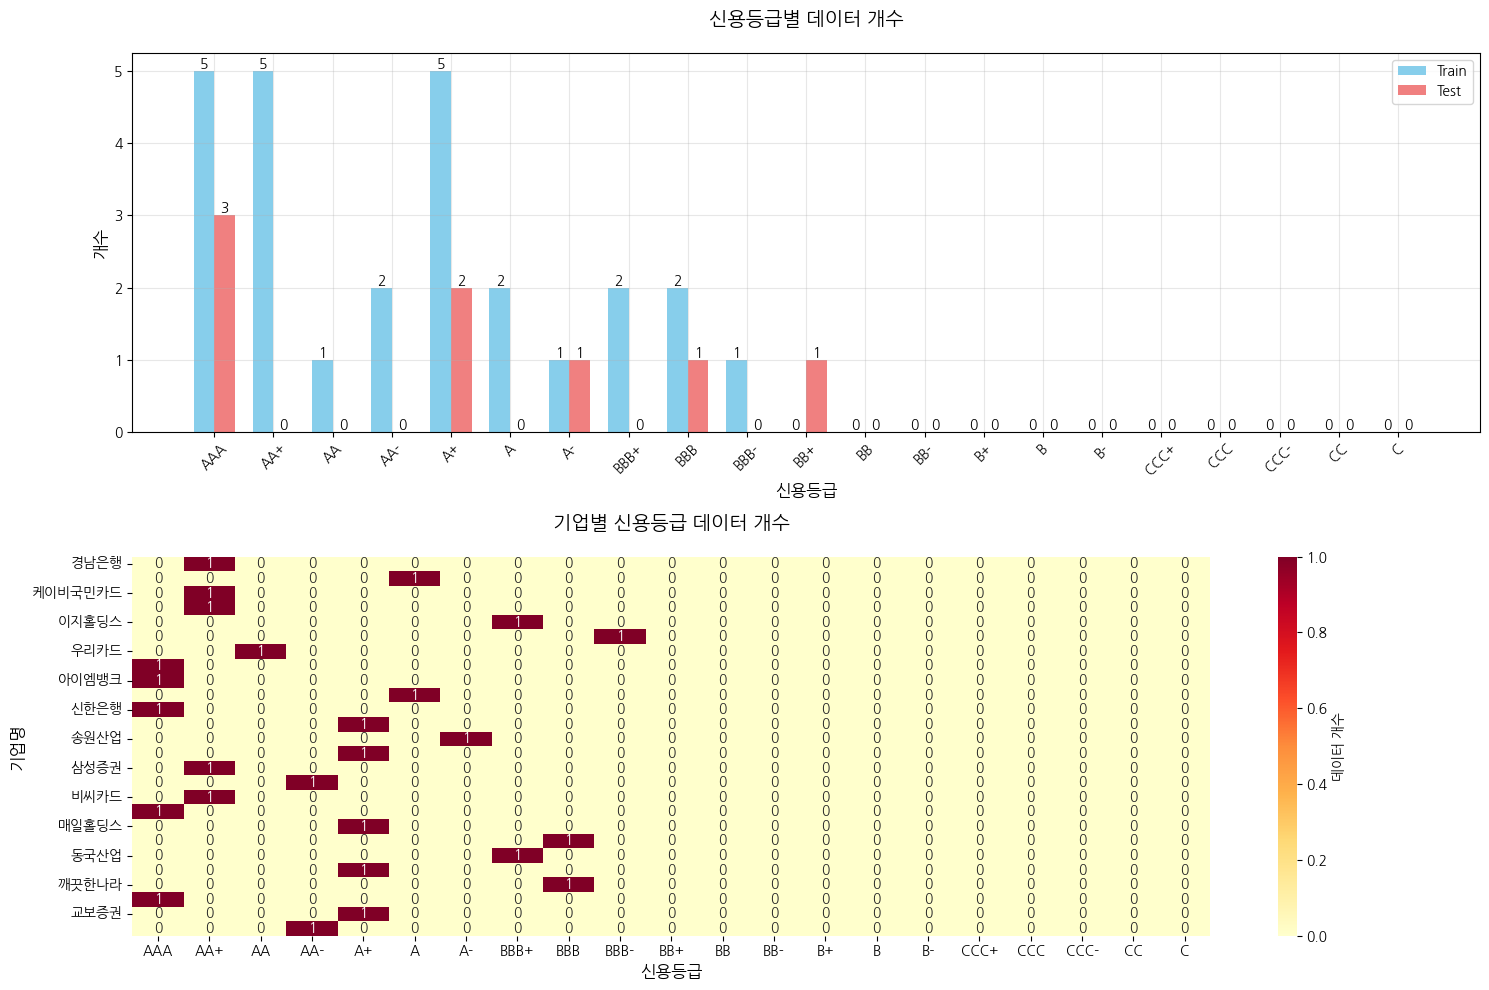

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

def get_rating_order():
    """신용등급 순서 정의"""
    return ['AAA', 'AA+', 'AA', 'AA-',
            'A+', 'A', 'A-',
            'BBB+', 'BBB', 'BBB-',
            'BB+', 'BB', 'BB-',
            'B+', 'B', 'B-',
            'CCC+', 'CCC', 'CCC-',
            'CC', 'C']

def load_and_analyze_credit_ratings(base_directory):
    """
    TRAIN과 TEST 디렉토리의 신용등급 데이터 분석
    """
    try:
        # 데이터 로드
        train_path = Path(base_directory) / 'TRAIN'
        test_path = Path(base_directory) / 'TEST'

        train_data = []
        test_data = []

        # 데이터 로드
        for file_path in train_path.glob('*.json'):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    train_data.append(json.load(f))
            except Exception as e:
                print(f"파일 로드 중 오류 발생 (TRAIN/{file_path.name}): {e}")
                continue

        for file_path in test_path.glob('*.json'):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    test_data.append(json.load(f))
            except Exception as e:
                print(f"파일 로드 중 오류 발생 (TEST/{file_path.name}): {e}")
                continue

        # DataFrame 변환
        train_df = pd.DataFrame(train_data)
        test_df = pd.DataFrame(test_data)

        # 신용등급 순서 설정
        rating_order = pd.CategoricalDtype(categories=get_rating_order(), ordered=True)
        train_df['credit_rating'] = train_df['credit_rating'].astype(rating_order)
        test_df['credit_rating'] = test_df['credit_rating'].astype(rating_order)

        # 분석 결과 출력
        print("\n=== TRAIN 데이터 신용등급 개수 ===")
        train_dist = train_df['credit_rating'].value_counts().sort_index()
        print(train_dist)
        print(f"\n총 데이터 수: {len(train_df):,}개")
        print(f"총 기업 수: {train_df['company'].nunique():,}개")

        print("\n=== TEST 데이터 신용등급 개수 ===")
        test_dist = test_df['credit_rating'].value_counts().sort_index()
        print(test_dist)
        print(f"\n총 데이터 수: {len(test_df):,}개")
        print(f"총 기업 수: {test_df['company'].nunique():,}개")

        # 시각화
        plt.figure(figsize=(15, 10))

        # 1. 전체 개수 비교 그래프
        plt.subplot(2, 1, 1)

        # 실제 존재하는 신용등급을 순서대로 정렬
        all_ratings = get_rating_order()
        existing_ratings = [r for r in all_ratings if r in train_dist.index or r in test_dist.index]
        x = range(len(existing_ratings))
        width = 0.35

        plt.bar([i - width/2 for i in x],
                [train_dist.get(rating, 0) for rating in existing_ratings],
                width, label='Train', color='skyblue')
        plt.bar([i + width/2 for i in x],
                [test_dist.get(rating, 0) for rating in existing_ratings],
                width, label='Test', color='lightcoral')

        plt.title('신용등급별 데이터 개수', pad=20, size=14)
        plt.xlabel('신용등급', size=12)
        plt.ylabel('개수', size=12)
        plt.xticks(x, existing_ratings, rotation=45)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # 각 막대 위에 숫자 표시
        for i in x:
            train_val = train_dist.get(existing_ratings[i], 0)
            test_val = test_dist.get(existing_ratings[i], 0)

            plt.text(i - width/2, train_val, str(train_val),
                    ha='center', va='bottom')
            plt.text(i + width/2, test_val, str(test_val),
                    ha='center', va='bottom')

        # 2. 기업별 분포
        plt.subplot(2, 1, 2)
        train_company_dist = train_df.groupby(['company', 'credit_rating']).size().unstack(fill_value=0)

        # 데이터가 있는 순서대로 정렬
        companies = train_company_dist.sum(axis=1).sort_values(ascending=False).index
        train_company_dist = train_company_dist.loc[companies]

        # 열(신용등급) 순서 정렬
        existing_columns = [col for col in all_ratings if col in train_company_dist.columns]
        train_company_dist = train_company_dist[existing_columns]

        sns.heatmap(train_company_dist,
                    cmap='YlOrRd',
                    annot=True,
                    fmt='g',  # 정수로 표시
                    cbar_kws={'label': '데이터 개수'})

        plt.title('기업별 신용등급 데이터 개수', pad=20, size=14)
        plt.xlabel('신용등급', size=12)
        plt.ylabel('기업명', size=12)

        plt.tight_layout()
        plt.show()

        return {
            'train_data': train_df,
            'test_data': test_df,
            'train_distribution': train_dist,
            'test_distribution': test_dist,
            'company_distribution': train_company_dist
        }

    except Exception as e:
        print(f"분석 중 오류 발생: {e}")
        return None

# 실행
base_dir = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/JSON"
results = load_and_analyze_credit_ratings(base_dir)